In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import numpy as np

import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import time
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
6


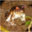

In [3]:
to_tensor_transform =transforms.Compose([
                           transforms.RandomHorizontalFlip(p=0.5),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]) # Normalize the Image        #ImageNet mean and std hence can be used for similar datasets)
                       ])

train = torchvision.datasets.CIFAR10("REU/data/",train = True,download = True,transform=None)       #Convert into tensors using transforms
test = torchvision.datasets.CIFAR10("REU/data/",train = False,download = True,transform = None)




trainset = torchvision.datasets.CIFAR10("REU/data/",train = True,download = True,transform = to_tensor_transform)       #Convert into tensors using transforms
testset = torchvision.datasets.CIFAR10("REU/data/",train = False,download = True,transform = to_tensor_transform)

for data,label in train:
    print(label)
    display(data)
    break
    
    

    
    


In [4]:
batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

for images,labels in trainloader:
    print(images.shape)
    print(labels)
    break

torch.Size([4, 3, 32, 32])
tensor([1, 5, 6, 4])


In [5]:
torch.seed()

class CNN(nn.Module):
    def __init__(self, classes=10, dropout_p=0.5):
        super().__init__()
        self.classes = classes

        self.feature_extractor = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=1),  
                nn.BatchNorm2d(num_features=64), # ADDED IN BATCHNORM

                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=5, stride=1),  
                nn.BatchNorm2d(num_features=64), # ADDED IN BATCHNORM
            
                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=1),  
                nn.BatchNorm2d(num_features=64), # ADDED IN BATCHNORM
            
                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=1),  
                nn.BatchNorm2d(num_features=64), # ADDED IN BATCHNORM


        )

        self.avgpool = nn.AdaptiveAvgPool2d((6,6))

        self.head = nn.Sequential(
                nn.Dropout(dropout_p),
                nn.Linear(64*6*6,128 ),
                nn.ReLU(),
                nn.Dropout(dropout_p),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, classes)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.feature_extractor(x)
        x = self.avgpool(x)
        x = x.reshape(batch_size, -1)
        x = self.head(x)
        return x
        
    
rand = torch.rand(1,3, 32, 32) 

model = CNN()
out = model(rand)
out.shape


torch.Size([1, 10])

In [6]:
rand = torch.rand(1,3, 128, 128) 

model = CNN()
out = model(rand)
out.shape

torch.Size([1, 10])

In [7]:
### SELECT DEVICE ###
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on Device {DEVICE}")

### LOAD IN and Modify CNN Model ###
model = CNN()
model = model.to(DEVICE)

### MODEL TRAINING INPUTS ###
epochs = 20
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(1,epochs+1):
    training_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = [] 
    print(f"Starting epoch {epoch}")
    
    model.train()
          
    for image,label in trainloader:
        image,label = image.to(DEVICE),label.to(DEVICE)

        optimizer.zero_grad()
        out = model.forward(image)

        ### CALCULATE LOSS ##
        loss = loss_fn(out, label)
        training_losses.append(loss.item())

        ### CALCULATE ACCURACY ###
        predictions = torch.argmax(out, axis=1)
        accuracy = (predictions == label).sum() / len(predictions)
        train_accuracies.append(accuracy.item())

        loss.backward()
        optimizer.step()

    model.eval() # Turn Off Batchnorm 
    for image, label in testloader:
        image, label = image.to(DEVICE), label.to(DEVICE)
        with torch.no_grad():
            out = model.forward(image)

            ### CALCULATE LOSS ##
            loss = loss_fn(out, label)
            test_losses.append(loss.item())

            ### CALCULATE ACCURACY ###
            predictions = torch.argmax(out, axis=1)
            accuracy = (predictions == label).sum() / len(predictions)
            test_accuracies.append(accuracy.item())

    training_loss_mean, training_acc_mean = np.mean(training_losses), np.mean(train_accuracies)
    valid_loss_mean, valid_acc_mean = np.mean(test_losses), np.mean(test_accuracies)
          
          
    train_loss.append(training_loss_mean)
    test_loss.append(valid_loss_mean)
    train_accuracy.append(training_acc_mean)
    test_accuracy.append(valid_acc_mean)
          
    print("Training Loss:", training_loss_mean) 
    print("Training Acc:", training_acc_mean)
    print("Validation Loss:", valid_loss_mean)
    print("Validation Acc:", valid_acc_mean)      
          
    
    
    
    

Training on Device cuda
Starting epoch 1
Training Loss: 1.5601817745542526
Training Acc: 0.43864
Validation Loss: 1.080584330162406
Validation Acc: 0.6184
Starting epoch 2
Training Loss: 1.2300656468904019
Training Acc: 0.57028
Validation Loss: 0.9480088505007327
Validation Acc: 0.665
Starting epoch 3
Training Loss: 1.1118204036778212
Training Acc: 0.61296
Validation Loss: 0.8713622816280462
Validation Acc: 0.6995
Starting epoch 4
Training Loss: 1.033765976626519
Training Acc: 0.6428
Validation Loss: 0.818405616896227
Validation Acc: 0.7189
Starting epoch 5
Training Loss: 0.9895792538491637
Training Acc: 0.65984
Validation Loss: 0.8093693964445032
Validation Acc: 0.7225
Starting epoch 6
Training Loss: 0.9422374414794147
Training Acc: 0.67622
Validation Loss: 0.7676063749638852
Validation Acc: 0.7322
Starting epoch 7
Training Loss: 0.9139640472128615
Training Acc: 0.68446
Validation Loss: 0.7431555233261548
Validation Acc: 0.745
Starting epoch 8
Training Loss: 0.883058401791267
Training

In [ ]:
#Change lr = 0.0001
#Output channels in Layer1 = 64
#Output (6,6)


##Added 2 more layers
#made kernel size 3 for last 2 layers

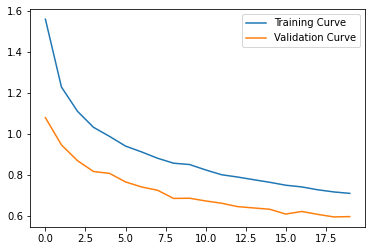

In [9]:
x = list(range(epochs))
plt.plot(x, train_loss, label="Training Curve")
plt.plot(x, test_loss, label="Validation Curve")
plt.legend()
plt.show()